In [3]:
#!pip install pennylane --upgrade

In [4]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.optimize import AdamOptimizer

dev = qml.device("default.qubit", wires=4)

## 1. Amplitude Implememtation

In [13]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])
    
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)

@qml.qnode(dev)
def test(angles):

    statepreparation(angles)

    return qml.expval(qml.PauliZ(0))


test(ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev.state))

def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

x               :  [0.53896774 0.79503606 0.27826503 0.        ]
angles          :  [ 0.56397465 -0.          0.         -0.97504604  0.97504604]
amplitude vector:  [ 5.38967743e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  7.95036065e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.78265032e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.77555756e-17  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [14]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias
    
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss
    
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)



## Loading the Dataset

###  Dataset was loaded from https://archive.ics.uci.edu/ml/datasets/iris

In [9]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/iris.txt",header=None)
data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width','label']
data = data[0:100]
data['label'].loc[data['label'] == 'Iris-setosa'] = -1.0
data['label'].loc[data['label'] == 'Iris-versicolor'] = 1.0
data = data.astype(float)
data = data.to_numpy()

# Labele the Data

X = data[:, 0:4]
print("First X sample (original)  :", X[0])

# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

Y = data[:, -1]



First X sample (original)  : [5.1 3.5 1.4 0.2]
First X sample (normalized): [0.80377277 0.55160877 0.22064351 0.0315205 ]
First features sample      : [ 0.44954297 -0.14189705  0.14189705 -0.60145471  0.60145471]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


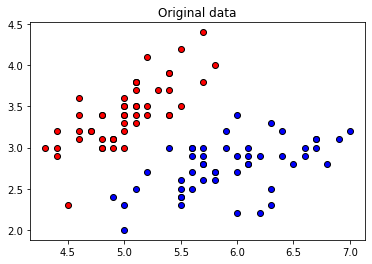

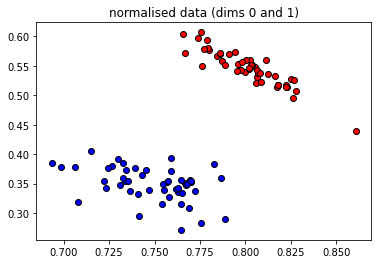

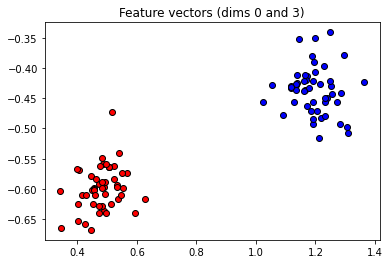

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()


In [11]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]


In [16]:
num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5
acc_train_1 = []
acc_val_1 = []

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    acc_train_1.append(acc_train)
    acc_val_1.append(acc_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 0.9645186 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 0.8791977 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 0.7759661 | Acc train: 0.5066667 | Acc validation: 0.5600000 
Iter:     4 | Cost: 0.7100915 | Acc train: 0.6933333 | Acc validation: 0.6800000 
Iter:     5 | Cost: 0.6647226 | Acc train: 0.9733333 | Acc validation: 0.8800000 
Iter:     6 | Cost: 0.6323180 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:     7 | Cost: 0.6254062 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:     8 | Cost: 0.6358865 | Acc train: 0.8666667 | Acc validation: 0.8400000 
Iter:     9 | Cost: 0.6620501 | Acc train: 0.6000000 | Acc validation: 0.5600000 
Iter:    10 | Cost: 0.6779210 | Acc train: 0.5600000 | Acc validation: 0.5600000 
Iter:    11 | Cost: 0.6860966 | Acc train: 0.5466667 | Acc validation: 0.5200000 
Iter:    12 | Cost: 0.6824719 | Acc train: 0.5466667 | Acc validation: 0.5200000 
Iter:    13 | Co

### Rotational Rx

In [17]:
# Remove the Angles from features
# angles for state preparation are new features
features = np.array([x for x in X], requires_grad=False)
print("First features sample      :", features[0])

np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]


def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

def statepreparation(a):
    for i in range(4):
      qml.RX(a[i],wires = i)

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5
acc_train_2 = []
acc_val_2 = []

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    acc_train_2.append(acc_train)
    acc_val_2.append(acc_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )


First features sample      : [5.1 3.5 1.4 0.2]
Iter:     1 | Cost: 0.6973994 | Acc train: 0.8400000 | Acc validation: 0.6800000 
Iter:     2 | Cost: 0.6836980 | Acc train: 0.8133333 | Acc validation: 0.7200000 
Iter:     3 | Cost: 0.6725637 | Acc train: 0.9200000 | Acc validation: 0.7600000 
Iter:     4 | Cost: 0.6606679 | Acc train: 0.9200000 | Acc validation: 0.7600000 
Iter:     5 | Cost: 0.6447429 | Acc train: 0.9200000 | Acc validation: 0.7600000 
Iter:     6 | Cost: 0.6270445 | Acc train: 0.9200000 | Acc validation: 0.7600000 
Iter:     7 | Cost: 0.6066828 | Acc train: 0.9200000 | Acc validation: 0.7600000 
Iter:     8 | Cost: 0.5855348 | Acc train: 0.9200000 | Acc validation: 0.7600000 
Iter:     9 | Cost: 0.5557477 | Acc train: 0.9333333 | Acc validation: 0.7600000 
Iter:    10 | Cost: 0.5298646 | Acc train: 0.9466667 | Acc validation: 0.8000000 
Iter:    11 | Cost: 0.5023356 | Acc train: 0.9600000 | Acc validation: 0.8000000 
Iter:    12 | Cost: 0.4756440 | Acc train: 0.960000

### Rotational RY

In [18]:
# Remove the Angles from features
# angles for state preparation are new features
features = np.array([x for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]


def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

def statepreparation(a):
    for i in range(4):
      qml.RY(a[i],wires = i)

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5
acc_train_3 = []
acc_val_3 = []

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    acc_train_3.append(acc_train)
    acc_val_3.append(acc_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )


First features sample      : [0.80377277 0.55160877 0.22064351 0.0315205 ]
Iter:     1 | Cost: 1.6658727 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.5891700 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.5368185 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.4859686 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.4183241 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.3402723 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     7 | Cost: 1.2583648 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     8 | Cost: 1.1785262 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     9 | Cost: 1.0682487 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    10 | Cost: 0.9991830 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    11 | Cost: 0.9472114 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    12 | Cost: 0.9

### Rotational RZ

In [19]:
# Remove the Angles from features
# angles for state preparation are new features
features = np.array([x for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]


def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

def statepreparation(a):
    for i in range(4):
      qml.RZ(a[i],wires = i)

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5
acc_train_4 = []
acc_val_4 = []

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    acc_train_4.append(acc_train)
    acc_val_4.append(acc_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )


First features sample      : [0.80377277 0.55160877 0.22064351 0.0315205 ]
Iter:     1 | Cost: 1.9514299 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.8811024 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.8235405 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.7635662 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.6899064 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.6081280 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     7 | Cost: 1.5232820 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     8 | Cost: 1.4396567 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     9 | Cost: 1.3322070 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    10 | Cost: 1.2503518 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    11 | Cost: 1.1756615 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    12 | Cost: 1.1

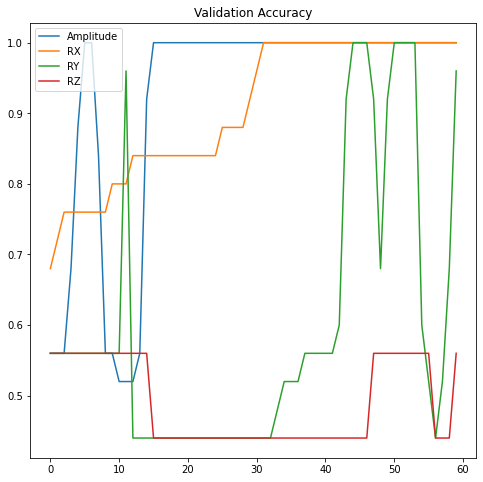

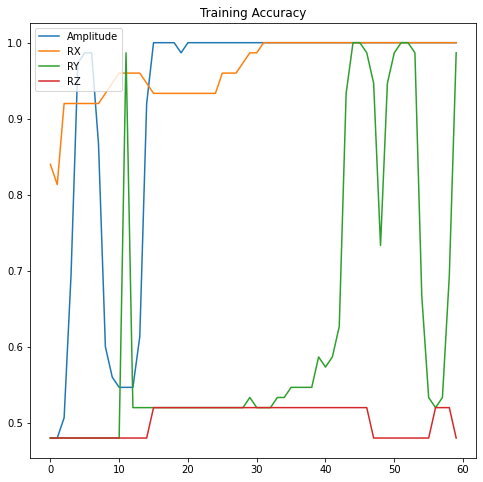

In [20]:
epochs_range = range(60)
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, acc_val_1, label='Amplitude')
plt.plot(epochs_range, acc_val_2, label='RX')
plt.plot(epochs_range, acc_val_3,label='RY')
plt.plot(epochs_range, acc_val_4, label='RZ')
plt.legend(loc='upper left')
plt.title('Validation Accuracy')
plt.show()

epochs_range = range(60)
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, acc_train_1, label='Amplitude')
plt.plot(epochs_range, acc_train_2, label='RX')
plt.plot(epochs_range, acc_train_3,label='RY')
plt.plot(epochs_range, acc_train_4, label='RZ')
plt.legend(loc='upper left')
plt.title('Training Accuracy')
plt.show()

## Variations in the Ansatz

In [21]:
## Ansatz 1:
# Remove the Angles from features
# angles for state preparation are new features
features = np.array([x for x in X], requires_grad=False)
print("First features sample      :", features[0])

np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]


def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)
    

def statepreparation(a):
    for i in range(4):
      qml.RX(a[i],wires = i)

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5
acc_train_5 = []
acc_val_5 = []

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    acc_train_5.append(acc_train)
    acc_val_5.append(acc_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )


First features sample      : [5.1 3.5 1.4 0.2]
Iter:     1 | Cost: 0.8621582 | Acc train: 0.6133333 | Acc validation: 0.6000000 
Iter:     2 | Cost: 0.8229335 | Acc train: 0.6133333 | Acc validation: 0.6000000 
Iter:     3 | Cost: 0.7952935 | Acc train: 0.6666667 | Acc validation: 0.6400000 
Iter:     4 | Cost: 0.7664193 | Acc train: 0.6666667 | Acc validation: 0.6400000 
Iter:     5 | Cost: 0.7145846 | Acc train: 0.6800000 | Acc validation: 0.7200000 
Iter:     6 | Cost: 0.6243781 | Acc train: 0.7466667 | Acc validation: 0.7600000 
Iter:     7 | Cost: 0.5597565 | Acc train: 0.8133333 | Acc validation: 0.9200000 
Iter:     8 | Cost: 0.5243811 | Acc train: 0.8666667 | Acc validation: 0.9600000 
Iter:     9 | Cost: 0.6232158 | Acc train: 0.7733333 | Acc validation: 0.7200000 
Iter:    10 | Cost: 0.6258134 | Acc train: 0.7733333 | Acc validation: 0.7200000 
Iter:    11 | Cost: 0.5621795 | Acc train: 0.7866667 | Acc validation: 0.7600000 
Iter:    12 | Cost: 0.5295756 | Acc train: 0.813333

In [22]:
## Ansatz 2:
# Remove the Angles from features
# angles for state preparation are new features
features = np.array([x for x in X], requires_grad=False)
print("First features sample      :", features[0])

np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]


def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.PauliY(wires = 0)
    qml.PauliY(wires = 1)
    qml.PauliY(wires = 2)
    qml.PauliY(wires = 3)

def statepreparation(a):
    for i in range(4):
      qml.RX(a[i],wires = i)

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5
acc_train_6 = []
acc_val_6 = []

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    acc_train_6.append(acc_train)
    acc_val_6.append(acc_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )


First features sample      : [5.1 3.5 1.4 0.2]
Iter:     1 | Cost: 0.8772912 | Acc train: 0.6133333 | Acc validation: 0.6000000 
Iter:     2 | Cost: 0.8560479 | Acc train: 0.6133333 | Acc validation: 0.6000000 
Iter:     3 | Cost: 0.8403927 | Acc train: 0.6133333 | Acc validation: 0.6000000 
Iter:     4 | Cost: 0.8250259 | Acc train: 0.6133333 | Acc validation: 0.6000000 
Iter:     5 | Cost: 0.8040911 | Acc train: 0.6666667 | Acc validation: 0.6400000 
Iter:     6 | Cost: 0.7774031 | Acc train: 0.6666667 | Acc validation: 0.6400000 
Iter:     7 | Cost: 0.7500989 | Acc train: 0.6666667 | Acc validation: 0.6400000 
Iter:     8 | Cost: 0.7220705 | Acc train: 0.6800000 | Acc validation: 0.7200000 
Iter:     9 | Cost: 0.6828844 | Acc train: 0.6800000 | Acc validation: 0.7200000 
Iter:    10 | Cost: 0.6556075 | Acc train: 0.7466667 | Acc validation: 0.7600000 
Iter:    11 | Cost: 0.6307270 | Acc train: 0.7466667 | Acc validation: 0.7600000 
Iter:    12 | Cost: 0.6091875 | Acc train: 0.786666

In [23]:
## Ansatz 3:
# Remove the Angles from features
# angles for state preparation are new features
features = np.array([x for x in X], requires_grad=False)
print("First features sample      :", features[0])

np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]


def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.PauliY(wires = 0)
    qml.PauliX(wires = 1)
    qml.PauliY(wires = 2)
    qml.PauliZ(wires = 3)
    qml.CNOT(wires=[0, 1])

def statepreparation(a):
    for i in range(4):
      qml.RX(a[i],wires = i)

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5
acc_train_7 = []
acc_val_7 = []

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    acc_train_7.append(acc_train)
    acc_val_7.append(acc_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )


First features sample      : [5.1 3.5 1.4 0.2]
Iter:     1 | Cost: 0.8778435 | Acc train: 0.6133333 | Acc validation: 0.6000000 
Iter:     2 | Cost: 0.8567728 | Acc train: 0.6133333 | Acc validation: 0.6000000 
Iter:     3 | Cost: 0.8412249 | Acc train: 0.6133333 | Acc validation: 0.6000000 
Iter:     4 | Cost: 0.8259644 | Acc train: 0.6133333 | Acc validation: 0.6000000 
Iter:     5 | Cost: 0.8052507 | Acc train: 0.6133333 | Acc validation: 0.6000000 
Iter:     6 | Cost: 0.7789886 | Acc train: 0.6666667 | Acc validation: 0.6400000 
Iter:     7 | Cost: 0.7522274 | Acc train: 0.6666667 | Acc validation: 0.6400000 
Iter:     8 | Cost: 0.7249661 | Acc train: 0.6666667 | Acc validation: 0.6400000 
Iter:     9 | Cost: 0.6874914 | Acc train: 0.6800000 | Acc validation: 0.7200000 
Iter:    10 | Cost: 0.6613365 | Acc train: 0.7466667 | Acc validation: 0.7600000 
Iter:    11 | Cost: 0.6376643 | Acc train: 0.7466667 | Acc validation: 0.7600000 
Iter:    12 | Cost: 0.6174426 | Acc train: 0.786666

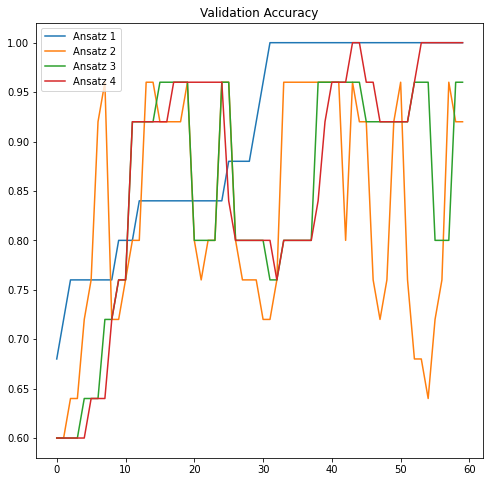

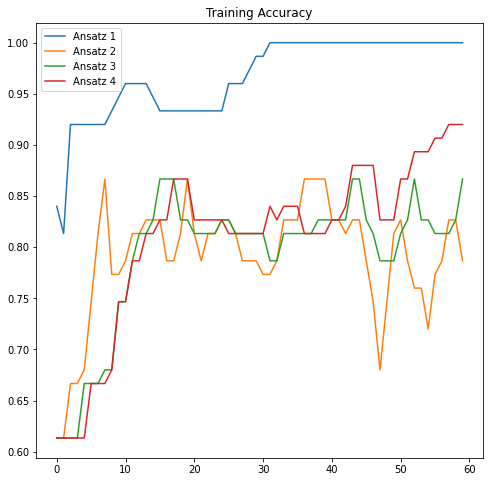

In [24]:
epochs_range = range(60)
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, acc_val_2, label='Ansatz 1')
plt.plot(epochs_range, acc_val_5,label='Ansatz 2')
plt.plot(epochs_range, acc_val_6, label='Ansatz 3')
plt.plot(epochs_range, acc_val_7, label='Ansatz 4')
plt.legend(loc='upper left')
plt.title('Validation Accuracy')
plt.show()

epochs_range = range(60)
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, acc_train_2, label='Ansatz 1')
plt.plot(epochs_range, acc_train_5,label='Ansatz 2')
plt.plot(epochs_range, acc_train_6, label='Ansatz 3')
plt.plot(epochs_range, acc_train_7, label='Ansatz 4')
plt.legend(loc='upper left')
plt.title('Training Accuracy')
plt.show()

## Change in Optimizer

In [25]:
# Remove the Angles from features
# angles for state preparation are new 

from pennylane.optimize import AdamOptimizer


features = np.array([x for x in X], requires_grad=False)
print("First features sample      :", features[0])

np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]


def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

def statepreparation(a):
    for i in range(4):
      qml.RX(a[i],wires = i)

num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = AdamOptimizer(0.01)
batch_size = 5
acc_train_8 = []
acc_val_8 = []

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    acc_train_8.append(acc_train)
    acc_val_8.append(acc_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )


First features sample      : [5.1 3.5 1.4 0.2]
Iter:     1 | Cost: 0.6942808 | Acc train: 0.8533333 | Acc validation: 0.6800000 
Iter:     2 | Cost: 0.6818123 | Acc train: 0.8133333 | Acc validation: 0.7200000 
Iter:     3 | Cost: 0.6698565 | Acc train: 0.9066667 | Acc validation: 0.7600000 
Iter:     4 | Cost: 0.6555517 | Acc train: 0.9200000 | Acc validation: 0.7600000 
Iter:     5 | Cost: 0.6378332 | Acc train: 0.9200000 | Acc validation: 0.7600000 
Iter:     6 | Cost: 0.6175176 | Acc train: 0.9200000 | Acc validation: 0.7600000 
Iter:     7 | Cost: 0.5940905 | Acc train: 0.9333333 | Acc validation: 0.7600000 
Iter:     8 | Cost: 0.5685936 | Acc train: 0.9466667 | Acc validation: 0.7600000 
Iter:     9 | Cost: 0.5404323 | Acc train: 0.9600000 | Acc validation: 0.8000000 
Iter:    10 | Cost: 0.5117584 | Acc train: 0.9600000 | Acc validation: 0.8000000 
Iter:    11 | Cost: 0.4819759 | Acc train: 0.9733333 | Acc validation: 0.8400000 
Iter:    12 | Cost: 0.4520922 | Acc train: 0.973333

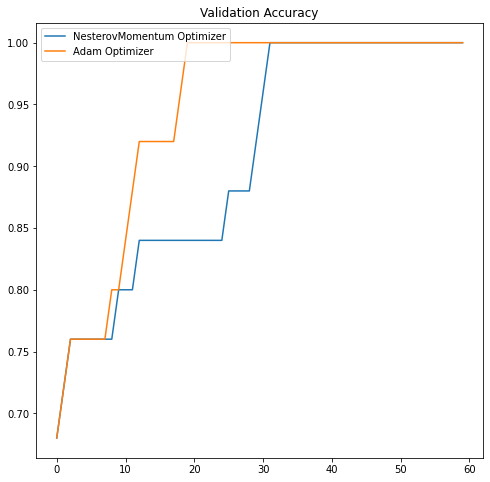

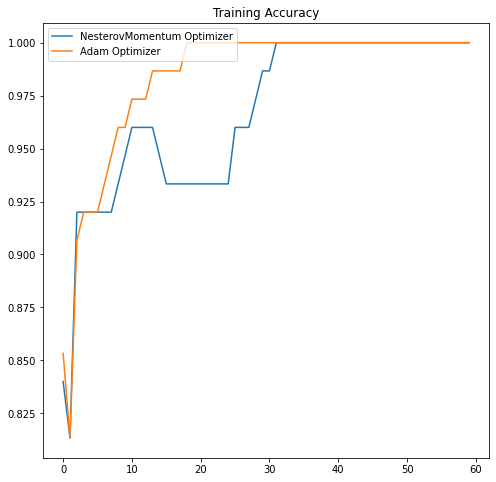

In [26]:
epochs_range = range(60)
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, acc_val_2, label='NesterovMomentum Optimizer')
plt.plot(epochs_range, acc_val_8, label='Adam Optimizer')
plt.legend(loc='upper left')
plt.title('Validation Accuracy')
plt.show()

epochs_range = range(60)
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, acc_train_2, label='NesterovMomentum Optimizer')
plt.plot(epochs_range, acc_train_8,label='Adam Optimizer')
plt.legend(loc='upper left')
plt.title('Training Accuracy')
plt.show()